The aim of this notebook is to demostrate the working of confluence, a new way for merging bboxes in object detection. Notes have been added from the paper to make it more clear.  

The paper link is: https://arxiv.org/pdf/2012.00257.pdf

# How does this algorithm work?
- Uses manhattan distance to find the closest boxes and removes the highly confluent bounding boxes.
- mAP improvement of 0.3-0.5% and recall improvement of 1.4-2.5%
- Confluence outperforms Greedy NMS in both mAP and recall, using the challenging 0.50:0.95 mAP evaluation metric. Superior non-IoU alternative to Greedy NMS which does not rely on IoU or the maxima confidence score in bounding box retention and suppression.

confluence_1.png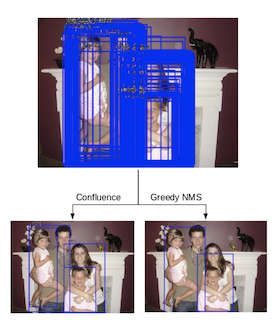

A proximity score is calculated, P. Each box is compared to every other boxes and the proximity scores is used to filter the confluent boxes.

proximity equ.png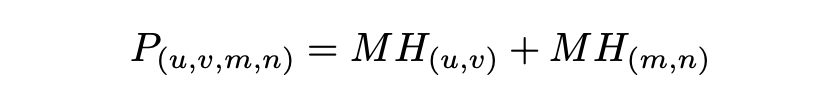

mh equ.png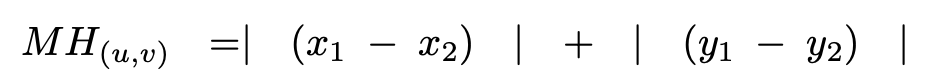

A graphical view of how proximity score is calculated.

P expanded figure.png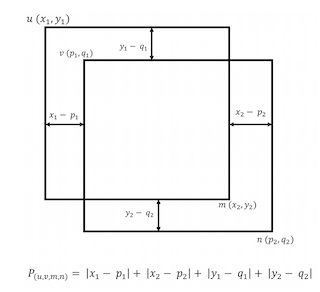

- A small value of P would denote highly confluent boxes while the high value of P would indicate that the boxes are not attributable to same objects.
- Thus a bounding box surrounded by dense cluster of boxes will be characterized by low values of P and in effect provides a object detector's confidence in presence of the object.
- the bounding box b with the lowest intra-cluster P values represents the most confident detection for a given object.
- Normalization is applied before finding the P value and the bbox can be of different sizes. Normalization allows the difference between the intraobject(same object represented by slightly misplaced objects) and interobjects(two different objects) to be distinguised.
- overcomes an issue faced by NMS and its alternatives - in situations where the highest scoring bounding box is sub-optimal in comparison with another lower scoring bounding box, NMS returns the sub-optimal bounding box, as illustrated by confluence_1.png. In contrast, the P measure allows for the bounding box which is most confluent with all other bounding boxes assigned a given object to be favoured, making it more robust.

inter and intra object p values.png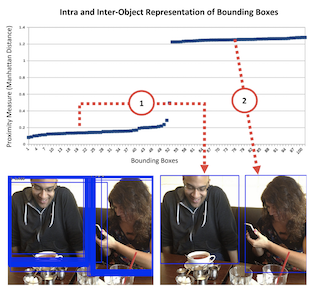

final P value is calculated:

Weighted P by Confidence.png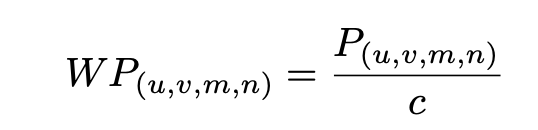

# Now comparison it with wbf 

In [ ]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 10)

In [ ]:
!pip install ensemble_boxes

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
sns.set(rc={"font.size":9,"axes.titlesize":15,"axes.labelsize":9,
            "axes.titlepad":11, "axes.labelpad":9, "legend.fontsize":7,
            "legend.title_fontsize":7, 'axes.grid' : False})
import cv2
import json
import pandas as pd
import glob
import os.path as osp
from path import Path
import datetime
import numpy as np
from tqdm.auto import tqdm
import random
import shutil
from sklearn.model_selection import train_test_split

from ensemble_boxes import *
import warnings
from collections import Counter


In [ ]:
df = pd.read_csv("../input/vinbigdata-competition-jpg-data-3x-downsampled/train_downsampled.csv")
df.head(5)

In [ ]:
#Ref : https://www.kaggle.com/sreevishnudamodaran/vinbigdata-fusing-bboxes-coco-dataset/data
def plot_img(img, size=(18, 18), is_rgb=True, title="", cmap='gray'):
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

def plot_imgs(imgs, cols=2, size=10, is_rgb=True, title="", cmap='gray', img_size=None):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    
def draw_bbox(image, box, label, color):   
    alpha = 0.1
    alpha_box = 0.4
    thickness = 1
    overlay_bbox = image.copy()
    overlay_text = image.copy()
    output = image.copy()
    label = str(label)
    text_width, text_height = cv2.getTextSize(label.upper(), cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)[0]
    cv2.rectangle(overlay_bbox, (box[0], box[1]), (box[2], box[3]),
                color, -1)
    cv2.addWeighted(overlay_bbox, alpha, output, 1 - alpha, 0, output)
    cv2.rectangle(overlay_text, (box[0], box[1]-7-text_height), (box[0]+text_width+2, box[1]),
                (0, 0, 0), -1)
    cv2.addWeighted(overlay_text, alpha_box, output, 1 - alpha_box, 0, output)
    cv2.rectangle(output, (box[0], box[1]), (box[2], box[3]),
                    color, thickness)
    cv2.putText(output, label.upper(), (box[0], box[1]-5),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)
    return output

In [ ]:
from random import randint

In [ ]:
image_id = "d3637a1935a905b3c326af31389cb846"

In [ ]:


label2Color = {i:(randint(1, 255), randint(1, 255), randint(1, 255)) for i in df.class_name.unique().tolist()}



In [ ]:
label2Color

In [ ]:
df[df.image_id==image_id]


In [ ]:
# draw_bbox(image, box, label, color)
# image_id = "d3637a1935a905b3c326af31389cb846"
def getBboxOnImage(image_id):
    img = cv2.imread(f"../input/vinbigdata-competition-jpg-data-3x-downsampled/train/train/{image_id}.jpg")
    for i, row in df[df.image_id=="d3637a1935a905b3c326af31389cb846"].iterrows():
        bbox = row[['x_min', 'y_min', 'x_max', 'y_max']].astype(int)
        _class = row['class_id']
        _class_name = row['class_name']
        img = draw_bbox(img, bbox, _class_name, label2Color[_class_name])
    return img

# Weighted Box Fusion

In [ ]:
def runBoxFusion(image_id):
    df_image_id = df[df.image_id==image_id]
    disease_image_id = df[df.image_id==image_id]['class_name'].unique().tolist()
    img_cp = cv2.imread(f"../input/vinbigdata-competition-jpg-data-3x-downsampled/train/train/{image_id}.jpg")
    for d in disease_image_id:
        height, width, _ = img.shape
        rows = df_image_id[df_image_id.class_name==d][['x_min', 'y_min', 'x_max', 'y_max']]
        bboxes = rows.to_numpy()
        bboxes = bboxes/(height, width, height, width)
        labels = np.ones(bboxes.shape[0])
        scores = np.ones(bboxes.shape[0])
        boxes, scores, labels = weighted_boxes_fusion([bboxes], [scores], [labels], iou_thr=0.4, skip_box_thr=0.4)
        boxes = boxes*(height, width, height, width)
        for bbox in boxes:
            img_cp = draw_bbox(img_cp, bbox.astype(int), d, label2Color[d])
    return img_cp


# Confluence Code

# Reference: https://github.com/lmk123568/OD_Confluence
The code for confluence has been taken from this repo

In [ ]:
def imshow(path, bbox):

    img = cv2.imread(path)

    bbox1 = bbox[:, :4].astype(int)

    min_point = [tuple(x) for x in bbox1[:, :2].tolist()]

    max_point = [tuple(x) for x in bbox1[:, 2:4].tolist()]

    for i in range(len(bbox)):
        cv2.rectangle(img, min_point[i], max_point[i], (0, 255, 0), 2)
    plt.figure(figsize= (12, 10))
    plt.imshow(img)

    plt.show()

In [ ]:

def norm(bbox1, bbox2):
    x1min, y1min, x1max, y1max = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2min, y2min, x2max, y2max = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    lx = max(x1min, x1max, x2min, x2max)-min(x1min, x1max, x2min, x2max)
    ly = max(y1min, y1max, y2min, y2max)-min(y1min, y1max, y2min, y2max)

    xmin = min(x1min, x1max, x2min, x2max)
    ymin = min(y1min, y1max, y2min, y2max)

    x1min = (x1min-xmin)/lx
    y1min = (y1min-ymin)/ly
    x2min = (x2min-xmin)/lx
    y2min = (y2min-ymin)/ly
    x1max = (x1max-xmin)/lx
    y1max = (y1max-ymin)/ly
    x2max = (x2max-xmin)/lx
    y2max = (y2max-ymin)/ly

    p = np.absolute(x1min-x2min)+np.absolute(x1max-x2max) + \
        np.absolute(y1min-y2min)+np.absolute(y1max-y2max)

    return p

In [ ]:
def confluence(bbox,threshold):
    
   
    print(30*'-')
    
    bbox_num=[i for i in range(len(bbox))]#Number each bbox
    
    keep = []

    while len(bbox_num) > 0:
        
        score_min = []#Store the minimum WP of each bbox in each round
        loc_set=[]#Store the bbox number where P<threshold of each bbox
        
        for i in bbox_num:
            score = []#Store all WPs of bbox[i], and then select the smallest
            loc=[]#Store the bbox number of P<threshold
            for j in bbox_num:
                P = norm(bbox[i], bbox[j])
                if P<threshold:
                    loc.append(j)
                print(f"P = {P}")
                if P < 2 and P != 0:
                    WP = P/bbox[i][4]
                    score.append(WP)
                    
            if len(score):       
                score_min.append(round(min(score), 3))
                loc_set.append(loc)
                
        
        if len(score_min)==0:
            return bbox
        print('Minimum WP for each bbox:', score_min)
        print('P<treshold of each bbox Another bbox number:',loc_set)
       
        
        index = score_min.index(min(score_min))
        bbox_index=bbox_num[index]
        print('Lowest score bbox number:',bbox_index)
        
        keep.append(bbox_index)
        print('Final bbox collection:',keep)
        print('Bbox number to delete',loc_set[index])
        
        for i in loc_set[index]:
            bbox_num.remove(i)
            
        
        print('The remaining bbox:',bbox_num)
        
        
        
        if len(bbox_num)==1:
            keep.append(bbox_num[0])
            print('1 left, merged into the final bbox',keep)
            break
        
        print(30*'-')
   
    bbox_process = bbox[keep]
    
    return bbox_process

adding confidences to each bbox at last = [xmin, ymin, xmax, ymax, confidence]

In [ ]:
def getConfluencedBBox(image_id):
    labels_per_box = []
    df_image_id = df[df.image_id==image_id]
    confluenced_bbox = []
    disease_image_id = df[df.image_id==image_id]['class_name'].unique().tolist()
    path = f"../input/vinbigdata-competition-jpg-data-3x-downsampled/train/train/{image_id}.jpg"
    img_cp = cv2.imread(f"../input/vinbigdata-competition-jpg-data-3x-downsampled/train/train/{image_id}.jpg")
    for d in disease_image_id:
        height, width, _ = img.shape
        rows = df_image_id[df_image_id.class_name==d][['x_min', 'y_min', 'x_max', 'y_max']]
        bboxes = rows.to_numpy()
        # add confidence to each bbox
        bboxes = np.insert(bboxes, 4, 1, axis=1)
        if bboxes.shape[0]:
            confluenced_bbox.append(confluence(bboxes, 0.8))
            labels_per_box.append([d]*len(bboxes))
    confluenced_bbox = np.concatenate(confluenced_bbox)
    labels_per_box = np.concatenate(np.array(labels_per_box))
    return confluenced_bbox, labels_per_box

In [ ]:
def getBboxOnImageViaConfluence(image_id):
    confluenced_bbox, labels_per_box = getConfluencedBBox(image_id)
    img_cp = cv2.imread(f"../input/vinbigdata-competition-jpg-data-3x-downsampled/train/train/{image_id}.jpg")
    for bbox, d in zip(confluenced_bbox, labels_per_box):
        img_cp = draw_bbox(img_cp, bbox.astype(int), d, label2Color[d])
    return img_cp

# Plotting func

In [ ]:
def plotComparisonImages(img, img_wbf, img_confluenced):
    plt.figure(figsize = (22, 20))
    ax = plt.subplot(1,3,1)
    ax.set_title("Diseases Marked by All Radiologist")
    plt.imshow(img)
    ax = plt.subplot(1,3,2)
    ax.set_title("Fused BBox - WBF")
    plt.imshow(img_wbf)
    ax = plt.subplot(1,3, 3)
    ax.set_title("Box Fusion - Confluence")
    plt.imshow(img_confluenced)
    plt.show()

# Sample 1

In [ ]:
image_id = "d3637a1935a905b3c326af31389cb846"
img = getBboxOnImage(image_id)
img_wbf = runBoxFusion(image_id)
img_confluenced = getBboxOnImageViaConfluence(image_id)
plotComparisonImages(img, img_wbf, img_confluenced)



# Sample 2

In [ ]:
image_id = "afb6230703512afc370f236e8fe98806"
img = getBboxOnImage(image_id)
img_wbf = runBoxFusion(image_id)
img_confluenced = getBboxOnImageViaConfluence(image_id)
plotComparisonImages(img, img_wbf, img_confluenced)



# Sample 3

In [ ]:
image_id = "7c1add6833d5f0102b0d3619a1682a64"
img = getBboxOnImage(image_id)
img_wbf = runBoxFusion(image_id)
img_confluenced = getBboxOnImageViaConfluence(image_id)
plotComparisonImages(img, img_wbf, img_confluenced)

